# **A Geospatial Assessment of Burn Severity and Social Vulnerability in the 2025 LA Wildfires**
*Author: Melannie Moreno Rolón*

You can access the link to the GitHub Repository for more information about this project [here](https://github.com/mmorenorolon/eds220-hwk4.git).

## **Overview**:
This blog brings together two complementary analyses to understand the impacts of the Palisades and Eaton fires that struck Los Angeles in January 2025. First, using Landsat 8 false-color imagery, the analysis visualizes burn scars by assigning infrared bands to visible colors to highlight burn severity and the spatial extent of the damage. Second, it examines the social dimensions of these wildfires by integrating Environmental Justice Index (EJI) data with the fire perimeters. Together, these methods show how geospatial data science can reveal not only the ecological effects of wildfire but also the uneven social landscape in which these fires occur.

## Highlights

- **Fire Perimeter Processing**

Used `geopandas` to import, clean, reproject, and merge Eaton and Palisades fire perimeter shapefiles. Confirmed consistency in CRS and prepared the data layers for spatial analysis and satellite overlay.

- **Satellite Imagery Handling & False-Color Composites**

Loaded Landsat 8 surface reflectance data with `xarray`, restored missing CRS information using `rioxarray`. I created both true-color (RGB) and false-color (SWIR–NIR–Red) composites using `matplotlib` to highlight burn scars and vegetation loss.

- **Environmental Justice Analysis**

Imported California Environmental Justice Index (EJI) data to perform spatial joins and clip operations with `geopandas`. I used `pandas` to isolate for the social-vulnerability variable of interest (E_DISABL) which represents the percent of residents with a disability.

- **Geospatial Visualization for Community Impact Assessment**

Combined the fire perimeters, satellite imagery, and EJI demographic data into comparative maps using `matplotlib` and `contextily` to reveal how wildfire footprints intersect with socially vulnerable communities in Los Angeles County.

### About the Data: Datasets Description

#### Landsat Data:
The NetCDF dataset `landsat8-2025-02-23-palisades-eaton.nc` contains atmospherically corrected surface reflectance data from the Landsat 8 satellite, published on February 23, 2025 through the [Microsoft Planetary Computer](https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2). It includes key spectral bands (red, green, blue, near-infrared, and shortwave infrared) clipped to the perimeters of the Eaton and Palisades Fires in Los Angeles County. The dataset stores geospatial metadata in the `spatial_ref` variable. With a spatial resolution of 30 meters, this dataset supports the creation of true color and false color composites to assess vegetation health, burn severity and the extent of fire scars. Date Accessed: 11/19/2025

#### Fire Perimeter Data:
The Palisades and Eaton Dissolved Fire Perimeters (2025) dataset, published on January 21, 2025 by the County of Los Angeles, provides dissolved boundary polygons for the Eaton and Palisades Fires. Derived from the NIFC FIRIS fire service, which originally contained daily perimeter snapshots, the boundaries were merged to create a single burn perimeter for each fire. One Eaton record (mission 2025-CALAC-009087) was excluded because buffered “destroyed” points did not reliably represent burned areas. The dataset is hosted on [ArcGIS Hub](https://hub.arcgis.com/maps/ad51845ea5fb4eb483bc2a7c38b2370c/about) and includes geospatial layers for both fire perimeters, which supports wildfire impact analysis, mapping and environmental monitoring. Date Accessed: 11/19/2025

#### Environmental Justice Index Data:
The [Environmental Justice Index](https://www.atsdr.cdc.gov/place-health/php/eji/eji-data-download.html) (EJI) dataset provides census-tract-level indicators that capture the social and demographic conditions shaping a community’s ability to prepare for, respond to, and recover from environmental hazards. The dataset includes variables related to socioeconomic status, housing and transportation, health vulnerability, and population characteristics. For this analysis, we downloaded the EJI data for California in 2024. Date Accessed: 11/21/2025

In [2]:
# Import libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import rioxarray as rio
import geopandas as gpd
import pandas as pd
import contextily as ctx

In this step, we loaded the Python packages used throughout the notebook. These libraries provide tools for working with geospatial raster and vector data, plotting imagery, handling coordinate reference systems (CRS), and managing arrays and tables. This foundation is necessary before reading the fire perimeter shapefiles and Landsat NetCDF imagery.

#### 2. Fire Perimeter Data Exploration
#### Eaton Fire Perimeter

#### Loading the Eaton Fire Perimeter
We begin by loading the Eaton Fire perimeter shapefile. This allows us to inspect the geometry structure, attribute fields, and CRS. Understanding the perimeter data ensures that it will align properly with the Landsat imagery later in the notebook.


In [5]:
# Read in Eaton fire perimeter data
eaton_fire = gpd.read_file(os.path.join('data','Eaton_Perimeter_20250121','Eaton_Perimeter_20250121.shp'))

# View the first five rows of the `eaton_fire` geodataframe
eaton_fire.head()

,OBJECTID,type,Shape__Are,Shape__Len,geometry
0,1,Heat Perimeter,2206.265625,270.199719,"POLYGON ((-13146936.686 4051222.067, -13146932..."
1,2,Heat Perimeter,20710.207031,839.204218,"POLYGON ((-13150835.463 4052713.929, -13150831..."
2,3,Heat Perimeter,3639.238281,250.304502,"POLYGON ((-13153094.697 4053057.596, -13153113..."
3,4,Heat Perimeter,1464.550781,148.106792,"POLYGON ((-13145097.740 4053118.235, -13145100..."
4,5,Heat Perimeter,4132.753906,247.960744,"POLYGON ((-13153131.126 4053196.882, -13153131..."


Next, we read in the Palisades fire perimeter data.

In [6]:
# Read in Palisades fire perimeter data
palis_fire = gpd.read_file(os.path.join('data','Palisades_Perimeter_20250121', 'Palisades_Perimeter_20250121.shp'))

# View the first five rows of the palis_fire perimeter geodataframe
palis_fire.head()

,OBJECTID,type,Shape__Are,Shape__Len,geometry
0,1,Heat Perimeter,1182.082031,267.101144,"POLYGON ((-13193543.302 4032913.077, -13193543..."
1,2,Heat Perimeter,2222.488281,185.498783,"POLYGON ((-13193524.155 4033067.953, -13193524..."
2,3,Heat Perimeter,21.011719,22.412814,"POLYGON ((-13193598.085 4033158.222, -13193598..."
3,4,Heat Perimeter,214.992188,76.639180,"POLYGON ((-13193654.249 4033146.033, -13193656..."
4,5,Heat Perimeter,44203.453125,1569.259764,"POLYGON ((-13194209.580 4033236.320, -13194209..."


### Merging Eaton and Palisades Perimeters
Because both perimeter shapefiles share the same CRS and attribute structure, we can safely merge them into one GeoDataFrame.  
This combined dataset (`fires`) streamlines visualization and overlay operations later in the notebook. The following code verifies that the CRS's are the same and share the same columns. In addition, we add a new column to be able to differentiate within our merged geodataframe which geometries correspond to the Palisades and Eaton fire perimeters.


In [7]:
# Check that both geodataframes share the same CRS
assert eaton_fire.crs == palis_fire.crs

In [8]:
# Add a new column to identify each fire's geometries within the dataframe
eaton_fire['fire_name'] = 'Eaton'
palis_fire['fire_name'] = 'Palisades'

In [9]:
# Concatenate both geodataframes
fires = gpd.GeoDataFrame(pd.concat([eaton_fire, palis_fire], ignore_index= True))

# View the first five rows of `fires`
fires.head()

,OBJECTID,type,Shape__Are,Shape__Len,geometry,fire_name
0,1,Heat Perimeter,2206.265625,270.199719,"POLYGON ((-13146936.686 4051222.067, -13146932...",Eaton
1,2,Heat Perimeter,20710.207031,839.204218,"POLYGON ((-13150835.463 4052713.929, -13150831...",Eaton
2,3,Heat Perimeter,3639.238281,250.304502,"POLYGON ((-13153094.697 4053057.596, -13153113...",Eaton
3,4,Heat Perimeter,1464.550781,148.106792,"POLYGON ((-13145097.740 4053118.235, -13145100...",Eaton
4,5,Heat Perimeter,4132.753906,247.960744,"POLYGON ((-13153131.126 4053196.882, -13153131...",Eaton


### Cleaning Column Names  
To make the dataset easier to work with, we standardize column names by converting them to lowercase and renaming fields such as `shape_are` to`area` and `shape_len` to `length`. Clean column names reduce ambiguity and improve readability in subsequent analyses.


In [6]:
# Simplify the geodataframe columns
fires.columns = (
    fires.columns
    .str.strip()          # remove leading or trailing spaces
    .str.lower()          # convert to lowercase
    .str.replace("__", "_")  # replace double underscores with single
)

# View the simplified geodataframe columns
fires.columns

Index(['objectid', 'type', 'shape_are', 'shape_len', 'geometry'], dtype='object')

In [7]:
# Rename the `shape_are` and `shape_len` columns
fires= fires.rename(columns={
    "shape_are": "area",
    "shape_len": "length"
})

# View the dataframe with the renamed columns
fires.columns

Index(['objectid', 'type', 'area', 'length', 'geometry'], dtype='object')

### 3. NetCDF data import and exploration

#### Loading the Landsat 8 Bands
Here, we load the individual spectral bands from the Landsat 8 dataset. Each band represents reflectance in a different portion of the electromagnetic spectrum. Because false color imagery relies on assigning SWIR, NIR, and Red bands to visible colors, loading these bands correctly is essential for constructing the final composite.


In [8]:
# Read in Landsat 8 data
landsat8 = xr.open_dataset('data/landsat8-2025-02-23-palisades-eaton.nc')

#### Quick Band Visualization
Plotting a single band provides an initial visual check and helps confirm that the dataset was read correctly. This is a useful diagnostic step before building composite imagery.


In [ ]:
# Quick visualization of the red band of the dataset
landsat8['red'].plot()

#### Summary of Preliminary Exploration for `landsat8`
 The dataset shows that the blue band contains 109 missing values, while the green band has only one; all other variables are complete with no missing data. The spatial dimensions are 1418 y‑coordinates by 2742 x‑coordinates. Band values are stored as integers, whereas the time variable is in datetime format. All measurements are expressed in meters, and the dataset is referenced to CRS EPSG:32611. 

### 4. Restoring Geospatial Information


In [ ]:
# Print the CRS of `landsat8` with `rio.crs`
print(landsat8.rio.crs)

In [ ]:
# Print the CRS by using accesing the spatial_ref.crs_wkt attribute of the dataset
landsat8.spatial_ref.crs_wkt

#### Restoring Missing Spatial Reference Information
Although the Landsat NetCDF file contains a `spatial_ref` variable, the CRS is not automatically recognized by rioxarray.  
Here we extract the WKT-formatted CRS stored inside `spatial_ref` and write it back to the dataset using `.rio.write_crs()`.  
This step is essential for aligning the raster dataset with the fire perimeter polygons.


In [9]:
# Recover the geospatial information and the spatial reference information 
landsat8.rio.write_crs('EPSG:32611', inplace=True)

# Print the CRS of the updated dataset
print(landsat8.rio.crs)

EPSG:32611


### 5. True Color Image

#### Creating a True Color Image
To generate a natural-looking image of the landscape, we combine the red, green, and blue bands.  
Because clouds and bright targets can skew pixel values, we use the `robust=True` parameter to rescale the display range and improve visualization. We also address missing values by replacing NaNs with zeros to avoid rendering warnings.


In [ ]:
# c. Identify which bands have missing values 
landsat8.isnull().sum()

The green and blue bands have missing values.

In [12]:
# d. Substitute any missing values in the dataset with zeroes
landsat8_filled = landsat8.fillna(0)

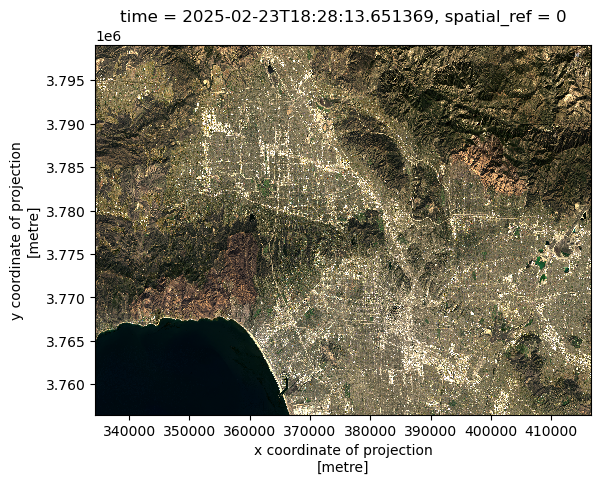

In [13]:
# e. Create a true color image without warnings
landsat8_filled[['red','green','blue']].to_array().plot.imshow(robust=True)

#### True Color Image Generation Takeaways
Because clouds are extremely bright, they can stretch the scale, so the non-cloud pixels are squeezed into a tiny part of the range. As a result, the entire image could look blank. However, after setting the `robust` parameter to 'True', this tells xarray to ignore the extreme outliers. This fixed the first warning. To identify which bands contain missing values, I used `landsat8.isnull().sum()`, which counts the number of missing pixels in each data variable. This revealed that the green and blue bands included NaN values. I applied `fillna(0)` to the dataset and then generated the true color image using the filled data. This ensured that the image plotted without warnings.

### 6. False Color Image

### Creating the False Color Composite
To highlight burn scars and vegetation health, we combine three Landsat bands into a false color image:
- **SWIR** → **Red channel**
- **NIR** → **Green channel**
- **Red** → **Blue channel**

This band arrangement enhances the visibility of burned regions and stressed vegetation. This visualization will make it easier to interpret fire impacts across the Palisades and Eaton areas.


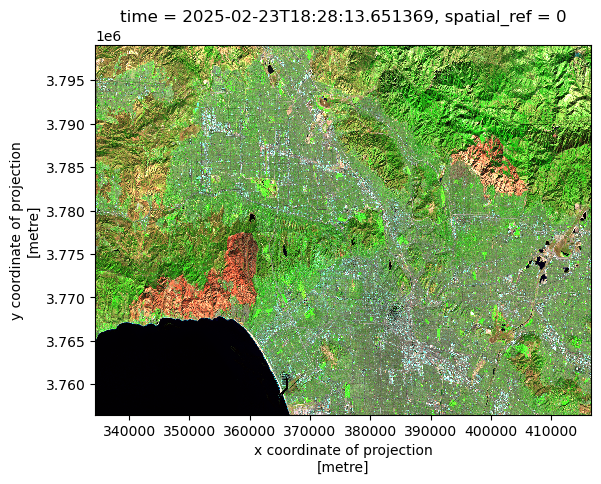

In [14]:
# Plot the short-wave infrared (swir22), near-infrared, and red variables (in that order)
landsat8_filled[['swir22', 'nir08', 'red']].to_array().plot.imshow(robust=True)

### 7. Map 

### Reprojecting Raster and Vector Data
The Landsat imagery and fire perimeter shapefiles may use different coordinate reference systems (CRS).  
To properly overlay perimeter polygons on the raster data, we reproject both datasets into a common CRS.  
This ensures that pixel locations align with fire boundaries on the map.


In [ ]:
# Verify that CRS's match
fires.crs == landsat8_filled.rio.crs

In [15]:
# Reproject the `fires` polygons to the landsat dataset
fires = fires.to_crs(landsat8_filled.rio.crs)

In [ ]:
# Check that the CRS's match after reprojection
fires.crs == landsat8.rio.crs

In [ ]:
print(fires.total_bounds)

#### Mapping Fire Perimeters on the False Color Composite
In this final visualization, we overlay the Eaton and Palisades fire boundaries on the false color image.  
This map reveals which areas exhibit increased SWIR reflectance, which is a strong indicator of recent burns, and confirms alignment with official fire perimeters. Text annotations help distinguish each fire footprint.


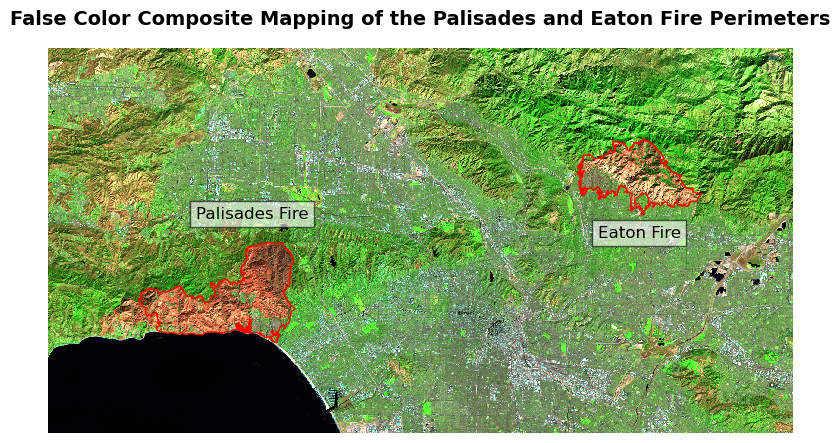

<Figure size 640x480 with 0 Axes>

In [16]:
# Create empty plot
fig, ax = plt.subplots(figsize=(11,5))
ax.axis('off')

# Show the shortwave infrared/near-infrared/red false color image together with both fire perimeters
landsat8_filled[['swir22', 'nir08', 'red']].to_array().plot.imshow(robust=True, ax = ax)
fires.plot(ax=ax, 
           legend=True,
           color = 'none',
           edgecolor='red')

# Add a title
ax.set_title("False Color Composite Mapping of the Palisades and Eaton Fire Perimeters", fontsize=14, fontweight='bold')

# Add text annotation for the Eaton Fire
ax.text(0.85, 0.5, "Eaton Fire",
        transform=ax.transAxes,  # relative to axes (0–1)
        ha="right", va="bottom",
        fontsize=12, bbox=dict(facecolor="white", alpha=0.6))

# Add text annotation for the Palisades Fire
ax.text(0.35, 0.55, "Palisades Fire",
        transform=ax.transAxes,  # relative to axes (0–1)
        ha="right", va="bottom",
        fontsize=12, bbox=dict(facecolor="white", alpha=0.6))

# Display plot
plt.show()
plt.tight_layout()

**More About the Use of False Color Imagery in this Figure**

The image above used the shortwave infrared (SWIR), near-infrared (NIR), and red band combination, which highlights the visibility of burned areas and stress on vegetation. In this false color scheme, healthy vegeation appears in bright green
In this combination, shortwave infrared (SWIR) is assigned to the red display channel, near-infrared (NIR) to green, and red light to blue. Burn scars appear in deep red tones, while SWIR reflectance increases after vegetation burns due to the loss of water content and exposure of burned soil. Vegetation reflects strongly in the NIR, which is mapped to the green channel in this composite, while Urban areas and developed land appear in shades of cyan or gray. Water appears very dark or black because both SWIR and NIR are almost completely absorbed by water. These spectral relationships allow the burned areas from the Palisades and Eaton fires to stand out strongly against the surrounding landscape. The fire perimeters (shown as transparent red polygons) align with the regions of intense SWIR reflectance. This map confirms the extent of the burn scars captured by Landsat.

# Social dimensions of Eaton and Palisades Fires

Wildfires do not impact all communities equally. Beyond the physical footprint of a burn scar, the social and demographic characteristics of nearby neighborhoods play a crucial role in shaping how residents experience, respond to, and recover from wildfire events. In this section, I explore the social dimensions of the Eaton and Palisades Fires by integrating census-tract–level indicators from the Environmental Justice Index (EJI) with each fire’s geographic perimeter.

In [3]:
# Read in the EJI dataset
ca_eji_fp = 'data/EJI_2024_California_GDB/EJI_2024_California/EJI_2024_California.gdb'
ca_eji = gpd.read_file(ca_eji_fp)

In [10]:
# Reproject all datasets to the same crs
palis_fire = palis_fire.to_crs(ca_eji.crs)
eaton_fire = eaton_fire.to_crs(ca_eji.crs)

In [11]:
# Get the EJI tracts intersecting the palisades fire perimeter
eji_palisades_join = gpd.sjoin(ca_eji, palis_fire, how='inner', predicate='intersects')

C:\Users\Melannie\AppData\Local\Temp\ipykernel_16792\740066065.py:15: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


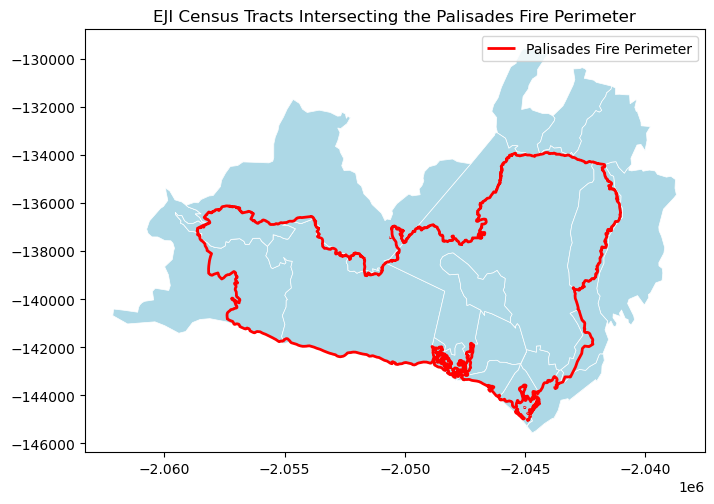

In [12]:
fig, ax = plt.subplots(figsize=(8, 8))

eji_palisades_join.plot(ax=ax, 
                        color="lightblue", 
                        edgecolor="white", 
                        linewidth=0.5,
                        label="Intersecting EJI Tracts")

palis_fire.boundary.plot(ax=ax,
                         color="red",
                         linewidth=2,
                         label="Palisades Fire Perimeter")

ax.set_title("EJI Census Tracts Intersecting the Palisades Fire Perimeter")
ax.legend()
plt.show()


In the case of the Palisades Fire, several entire census tracts fall completely inside the fire perimeter, while others intersect only along the edges. This means the fire footprint is large relative to the size of nearby census tracts, covering substantial portions of the local communities. Unlike many wildfires that only clip small parts of multiple tracts, the Palisades Fire burned through whole tracts, indicating that the impacted population and built environment may span multiple full census units.

In [13]:
# Get the EJI tracts intersecting the eaton fire perimeter
eji_eaton_join = gpd.sjoin(ca_eji, eaton_fire, how='inner', predicate='intersects')

C:\Users\Melannie\AppData\Local\Temp\ipykernel_16792\2830857761.py:19: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


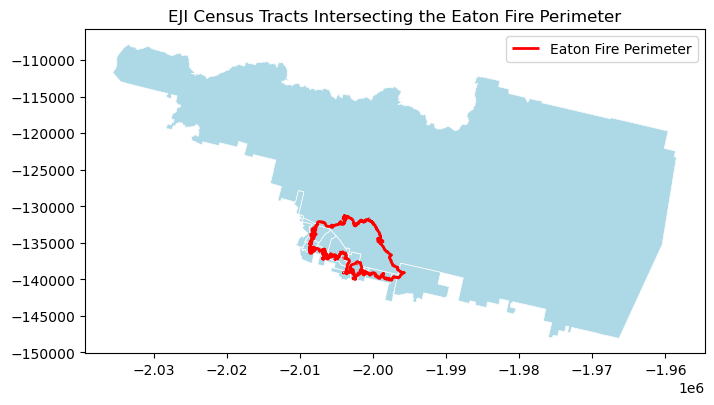

In [14]:
fig, ax = plt.subplots(figsize=(8, 8))

eji_eaton_join.plot(
    ax=ax, 
    color="lightblue", 
    edgecolor="white", 
    linewidth=0.5,
    label="Intersecting EJI Tracts"
)

eaton_fire.boundary.plot(
    ax=ax,
    color="red",
    linewidth=2,
    label="Eaton Fire Perimeter"
)

ax.set_title("EJI Census Tracts Intersecting the Eaton Fire Perimeter")
ax.legend()
plt.show()

Like the Palisades fire, the Eaton fire boundary is small relative to the size of census tracts. Only a few tracts intersect the fire perimeter, and each tract contains a much larger land area than the fire itself. This illustrates that tract-level EJ metrics aggregate social information across regions far larger than the fire footprint.

In [15]:
# Clip tracts to the palisades and eaton fire perimeters
eji_palis_clip = gpd.clip(ca_eji, palis_fire)
eji_eaton_clip = gpd.clip(ca_eji, eaton_fire)

#### Difference between a spatial join and clipping

**Spatial Join `ppd.sjoin()`**

Returns entire census tracts that touch the fire perimeter and the geometry remains unchanged. 

**Clipping `gpd.clip()`**

Returns only the portion of each tract inside the fire perimeter and the geometry is modified.

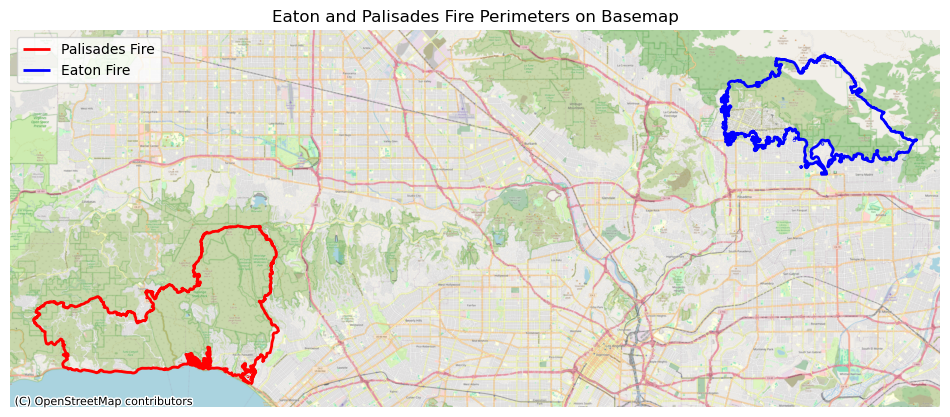

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

# Reproject to Web Mercator for basemap
palisades_3857 = palis_fire.to_crs(epsg=3857)
eaton_3857 = eaton_fire.to_crs(epsg=3857)

# Get bounds from each fire
pminx, pminy, pmaxx, pmaxy = palisades_3857.total_bounds
eminx, eminy, emaxx, emaxy = eaton_3857.total_bounds

minx = min(pminx, eminx)
miny = min(pminy, eminy)
maxx = max(pmaxx, emaxx)
maxy = max(pmaxy, emaxy)

# Plot 
fig, ax = plt.subplots(figsize=(12, 10))

# Set zoom *before* adding basemap
buffer = 2000  # small padding around the fire
ax.set_xlim(minx - buffer, maxx + buffer)
ax.set_ylim(miny - buffer, maxy + buffer)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=13)

# Plot fire boundaries
palisades_3857.boundary.plot(ax=ax, color="red", linewidth=2, label="Palisades Fire")
eaton_3857.boundary.plot(ax=ax, color="blue", linewidth=2, label="Eaton Fire")

# Legend + title
ax.legend(loc = 'upper left')
ax.set_title("Eaton and Palisades Fire Perimeters on Basemap")
ax.axis("off")

plt.show()


The map above displays the locations and extents of the Palisades Fire (outlined in red) and the Eaton Fire (outlined in blue) over a detailed OpenStreetMap basemap of the Los Angeles region. Overlaying the fire boundaries on a familiar street-level basemap allows for clear interpretation of their urban and ecological contexts. This map shows the proximity of the perimeters to major roadways, neighborhoods and parks.

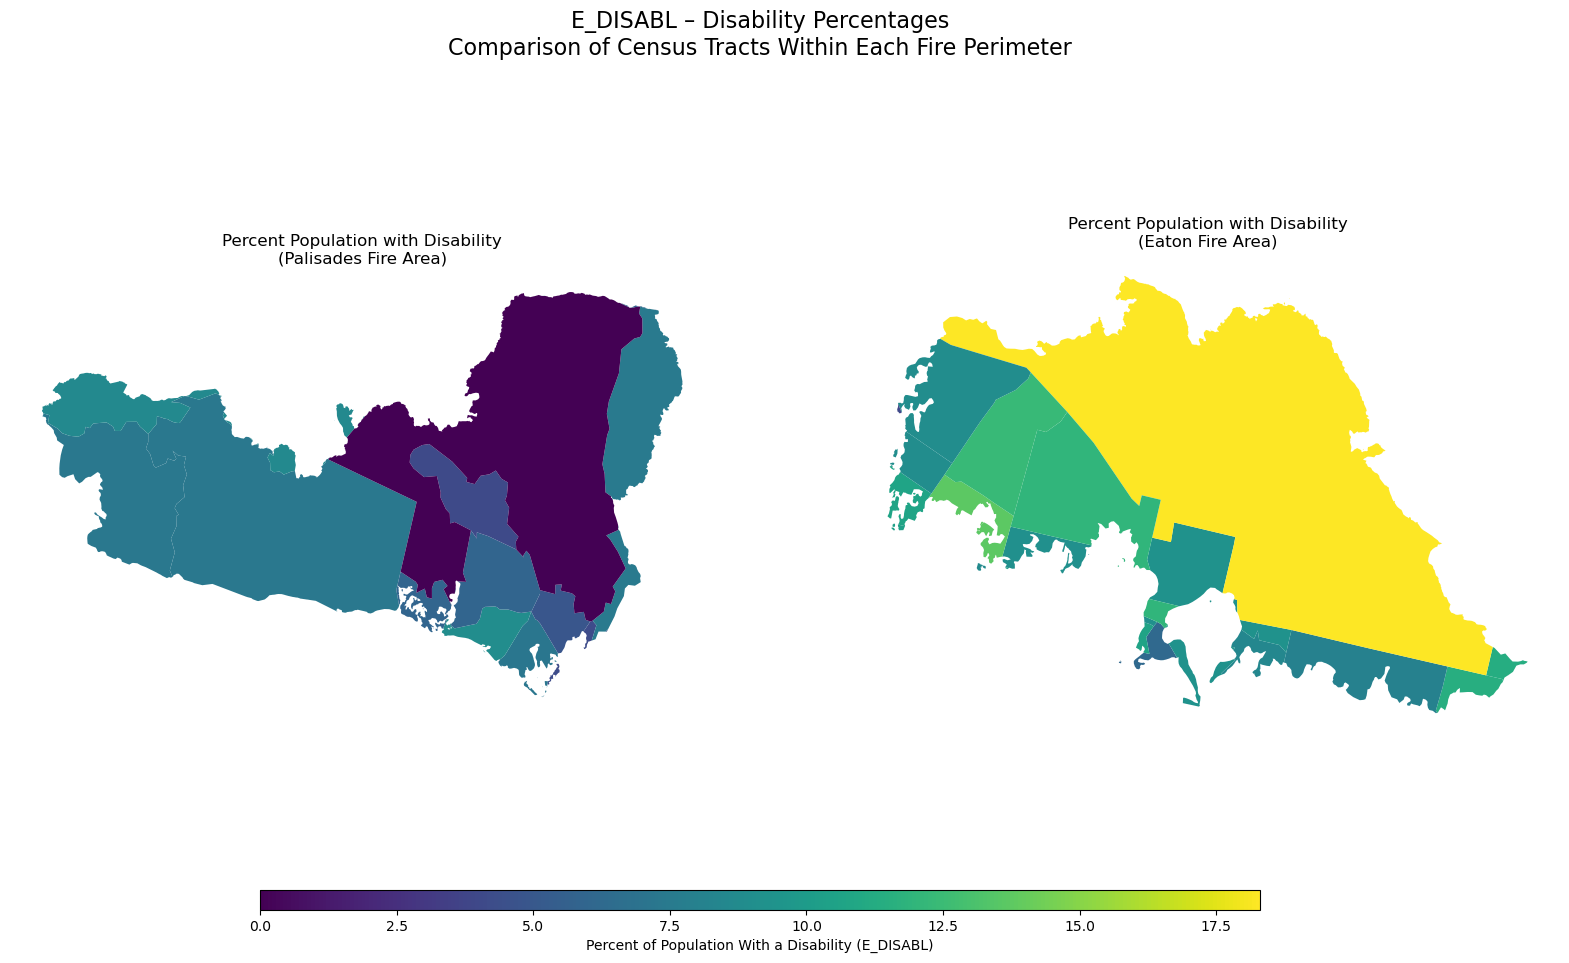

<Figure size 640x480 with 0 Axes>

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Percentage of persons with a disability
eji_variable = 'E_DISABL'

# Find shared min/max across both datasets
vmin = min(eji_palis_clip[eji_variable].min(),
           eji_eaton_clip[eji_variable].min())

vmax = max(eji_palis_clip[eji_variable].max(),
           eji_eaton_clip[eji_variable].max())

# --- Palisades plot ---
eji_palis_clip.plot(
    column=eji_variable,
    vmin=vmin, vmax=vmax,
    legend=False,
    ax=ax1,
    cmap="viridis"
)
ax1.set_title('Percent Population with Disability\n(Palisades Fire Area)')
ax1.axis('off')

# --- Eaton plot ---
eji_eaton_clip.plot(
    column=eji_variable,
    vmin=vmin, vmax=vmax,
    legend=False,
    ax=ax2,
    cmap="viridis"
)
ax2.set_title('Percent Population with Disability\n(Eaton Fire Area)')
ax2.axis('off')

# Overall title
fig.suptitle('E_DISABL – Disability Percentages\nComparison of Census Tracts Within Each Fire Perimeter',
             fontsize=16)

# Shared horizontal colorbar
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar_ax = fig.add_axes([0.25, 0.08, 0.5, 0.02]) 
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Percent of Population With a Disability (E_DISABL)')

plt.show()
plt.tight_layout()

The distribution of `E_DISABL`, or the percent of residents with disabilities, differs noticeably between the census tracts intersecting the Palisades and Eaton fire perimeters. In the Palisades area, disability percentages are generally lower and more varied, with many tracts falling in the lower end of the color scale. In contrast, the Eaton fire area shows consistently higher disability rates across most tracts, with several communities displaying some of the highest values in the comparison. These differences have important implications for wildfire relief and recovery efforts. Communities with higher proportions of residents with disabilities may face additional challenges during evacuation, communication, and rebuilding phases. This means that emergency managers and recovery planners may need to allocate more targeted resources like accessible transportation, medical support, and long-term housing assistance to the Eaton area to ensure equitable and effective wildfire response.

### References:
Microsoft. (2025). *landsat8-2025-02-23-palisades-eaton.nc (Version 1.0) [Dataset]*. Microsoft Planetary Computer. https://planetarycomputer.microsoft.com

County of Los Angeles. (2025). *Palisades and Eaton dissolved fire perimeters (Version 1.0) [Dataset]*. ArcGIS Hub. https://hub.arcgis.com/maps/ad51845ea5fb4eb483bc2a7c38b2370c/about

CDC/ATSDR. (2025). *Environmental Justice Index (EJI) data download (Version 1.0) [Dataset]*. ATSDR/CDC. https://www.atsdr.cdc.gov/place-health/php/eji/eji-data-download.html